# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparatifs](#init)
* [2. Recherche du `pré-traitement` le plus adapté](#PREPROCESS)
    * [2.1 Tokenisation](#PREPROCESS_tokenized)
    * [2.2 Tokenisation + Filtrage](#PREPROCESS_filtered)
    * [2.3 Tokenisation + Filtrage + Lemmatisation](#PREPROCESS_lemmatized)
    * [2.4 Comparaison des scores](#PREPROCESS_scores)
* [3. Recherche du `plongement` le plus adapté](#EMBEDDING)
    * [3.1 Word2Vec](#EMBEDDING_Word2Vec)
    * [3.2 FastText](#EMBEDDING_FastText)
    * [3.3 Comparaison des scores](#EMBEDDING_scores)
* [4. Recherche du `modèle` de classification le plus adapté](#CLF)

In [1]:
import time
import pathlib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
try:
    from keras.utils import pad_sequences
except ImportError:
    from keras.preprocessing.sequence import pad_sequences

import joblib

random_seed = 0
np.random.seed(random_seed)

# set random seed for keras reproductibility
try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)

2022-07-29 14:44:50.800349: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


---
---
# 1. Préparatifs pour de la classification avec des réseaux de neurones <a class="anchor" id="init"></a> [⇪](#menu)

#### Chargeons les fonctions de classification écrites sur les projets précédents

In [2]:
from classification_utils import fit_model, get_scores, init_scores

init_scores("data/scores_NN.csv")

#### Définissons les fonctions génériques de notre Spot Checking 

In [3]:
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

In [4]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

In [5]:
def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.epoch{{epoch:02d}}-accuracy{{val_accuracy:.2f}}.hdf5")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=6,  # 6 because ReduceLROnPlateau is 5 
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )

    # Define Automatic LearningRate adjustments
    lr_reducer = ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.1,
        cooldown=5,
        patience=5,
        min_lr= 0.1e-5,
        verbose=1,
    )
    
    return [checkpoint, es, lr_reducer]

#### Définissons nos fonctions de perte, d'optimisation et les métriques à surveiller

In [6]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.BinaryCrossentropy(from_logits=False)
f_metrics = ['accuracy'] # in this context 'accuracy' == keras.metrics.BinaryAccuracy()

#### Définissons une méthode de `cross-validation`

In [7]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

---
---
# 2. Recherche du `pré-traitement` le plus adapté <a class="anchor" id="PREPROCESS"></a> [⇪](#menu)

Pour rechercher le pré-traitement le plus adapté, nous allons essayer différents jeux de données préparés lors de l'EDA.
Mais pour éviter tout autre changement, nous allons dans un premier temps définir une architecture NN simple et un Embedding de base que nous allons utiliser pour comparer l'influence des différents pré-traitement.

In [8]:
def architecture1(f_opti, f_loss, f_metrics, embedding):
    
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.GlobalMaxPooling1D()(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

---
## 2.1 Jeu de données BRUT (RAW) <a class="anchor" id="PREPROCESS_tokenized"></a> [⇪](#menu)

### Chargeons le jeu de données brut (RAW) pour nos premiers essais

In [9]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_raw.bin')
data_nlp = joblib.load(data_nlp_path)

In [10]:
sample_size = 100000
data_nlp = data_nlp.sample(sample_size, random_state=random_seed)

In [11]:
display(data_nlp.head(2), data_nlp.shape)

,tokens_raw,target
1303215,"[@RichGolisch, Thanks!]",1
1121114,"[Trying, to, get, a, babysitter, and, be, 999,...",1


(100000, 2)

In [12]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_nlp['tokens_raw'], data_nlp.target, test_size=0.2, random_state=random_seed)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [13]:
def preprocess_data_RAW(X_train, X_test, tokenizer_num_words=2000, padding_size=35, verbose=1):
    tokenizer = Tokenizer(num_words=tokenizer_num_words)
    tokenizer.fit_on_texts(X_train)

    dictionary = tokenizer.word_index
    vocab_size = len(dictionary)+1
    
    X_train_enc = tokenizer.texts_to_sequences(X_train)
    X_test_enc = tokenizer.texts_to_sequences(X_test)
    
    X_train_ready = pad_sequences(X_train_enc, padding='post', maxlen=padding_size)
    X_test_ready = pad_sequences(X_test_enc, padding='post', maxlen=padding_size)
    
    # y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
    # y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
    
    if verbose > 0:
        print("----- One sample outputs for demo -----")
        print(f">> Sentence: {tokenizer.sequences_to_texts(X_train_ready[:1])}")
        print(f">> X_train_enc: {X_train_enc[:1]}")
        print(f">> X_train_ready: {X_train_ready[:1]}")
        
        print(f"\nVocab size: {vocab_size}")
    
    return X_train_ready, X_test_ready, tokenizer, vocab_size

In [14]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, 2000, 35)

----- One sample outputs for demo -----
>> Sentence: ["same here. i know how it sucks that people actually don't appreciate your service is not an easy one"]
>> X_train_enc: [[248, 544, 1, 67, 70, 11, 352, 16, 144, 290, 49, 1105, 38, 1182, 8, 24, 78, 921, 66]]
>> X_train_ready: [[ 248  544    1   67   70   11  352   16  144  290   49 1105   38 1182
     8   24   78  921   66    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]

Vocab size: 129013


### Entrainons notre Neural Network 

In [15]:
embedding = layers.Embedding(vocab_size, 256, trainable=False)

In [16]:
archi01_model_RAW = architecture1(f_opti, f_loss, f_metrics, embedding)

2022-07-29 14:44:55.987127: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-29 14:44:55.988256: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-29 14:44:56.063685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-29 14:44:56.064262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-07-29 14:44:56.064303: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-29 14:44:56.065890: I tensorflow/stream_executor/platform/default/dso_loade

In [17]:
archi01_model_RAW.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         33027328  
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         229504    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512 

In [18]:
t0 = time.perf_counter()
history_clf_archi01_RAW = archi01_model_RAW.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=32, callbacks=init_callbacks("archi01_RAW")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50


2022-07-29 14:44:57.322590: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-29 14:44:57.340743: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2500000000 Hz
2022-07-29 14:44:57.759609: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-07-29 14:44:58.000023: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-07-29 14:44:59.213579: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-07-29 14:44:59.269608: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


2500/2500 [==============================] - 10s 3ms/step - loss: 0.6718 - accuracy: 0.5766 - val_loss: 0.6234 - val_accuracy: 0.6568

Epoch 00001: val_accuracy improved from -inf to 0.65680, saving model to models/archi01_RAW.epoch01-accuracy0.66.hdf5
Epoch 2/50
2500/2500 [==============================] - 6s 3ms/step - loss: 0.6247 - accuracy: 0.6500 - val_loss: 0.6103 - val_accuracy: 0.6591

Epoch 00002: val_accuracy improved from 0.65680 to 0.65910, saving model to models/archi01_RAW.epoch02-accuracy0.66.hdf5
Epoch 3/50
2500/2500 [==============================] - 6s 3ms/step - loss: 0.6068 - accuracy: 0.6692 - val_loss: 0.6004 - val_accuracy: 0.6750

Epoch 00003: val_accuracy improved from 0.65910 to 0.67495, saving model to models/archi01_RAW.epoch03-accuracy0.67.hdf5
Epoch 4/50
2500/2500 [==============================] - 6s 2ms/step - loss: 0.5780 - accuracy: 0.6931 - val_loss: 0.5972 - val_accuracy: 0.6743

Epoch 00004: val_accuracy did not improve from 0.67495
Epoch 5/50
2500

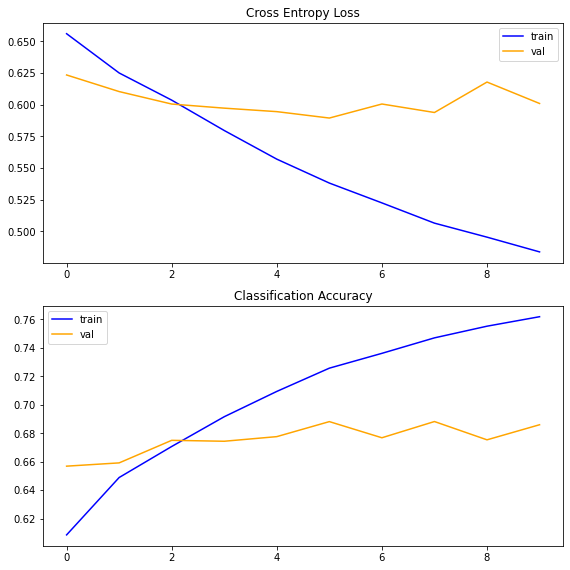

In [19]:
summarize_diagnostics(history_clf_archi01_RAW)

### Affichons les scores du modèle

In [20]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_RAW.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0


y_preds_proba.shape
y_preds.shape

(20000, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (RAW + TF-IDF) ----------------------------------------------------------------------

             ROC_AUC : 0.7507
                  F1 : 0.7120
            ACCURACY : 0.6743
           PRECISION : 0.6403
              RECALL : 0.8017
   AVERAGE_PRECISION : 0.7453

       TRAINING-TIME : 70.3429
      INFERENCE-TIME : 0.7734

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.73      0.55      0.63      9958
Prediction = 1       0.64      0.80      0.71     10042

      accuracy                           0.67     20000
     macro avg       

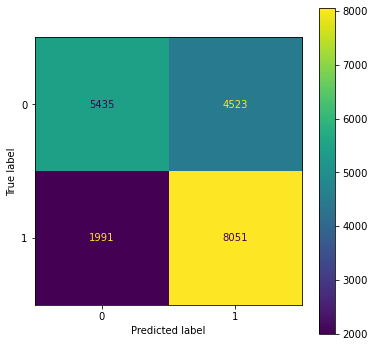

--- ROC AUC ---------------------------------------------------------------------------------------- 



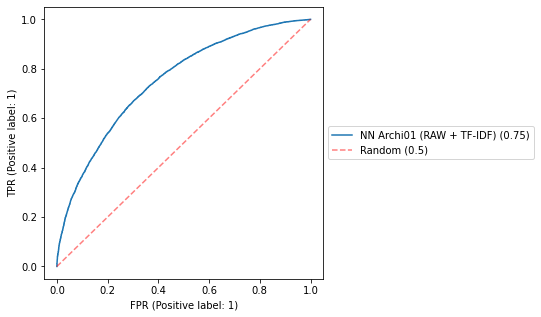

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



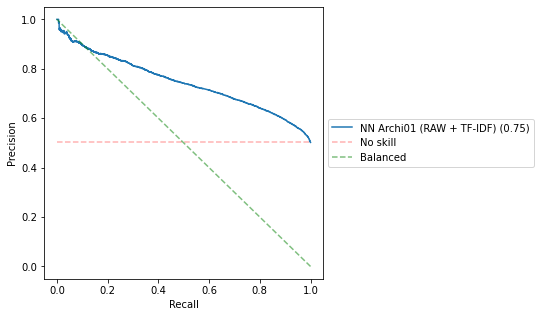

In [21]:
model_name = "NN Archi01 (RAW + TF-IDF)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 2.2 TOKENISATION + FILTRAGE <a class="anchor" id="PREPROCESS_filtered"></a> [⇪](#menu)

### Chargeons et appliquons le pré-traitement sur le jeu de données tokenisé & filtré

In [22]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_filtered.bin')
data_nlp = joblib.load(data_nlp_path)

In [23]:
data_nlp = data_nlp.sample(sample_size, random_state=random_seed)

In [24]:
display(data_nlp.head(2), data_nlp.shape)

,tokens_filtered,target
33683,"[wretched, weather, note, washed, car]",0
1346934,"[congrats, man, looks, like, fierce, eyes]",1


(100000, 2)

In [25]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_nlp['tokens_filtered'], data_nlp.target, test_size=0.2, random_state=random_seed)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [26]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, 2000, 35)

----- One sample outputs for demo -----
>> Sentence: ['fucking hero yo']
>> X_train_enc: [[352, 1249, 1570]]
>> X_train_ready: [[ 352 1249 1570    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]

Vocab size: 36785


### Entrainons notre Neural Network 

In [28]:
embedding = layers.Embedding(vocab_size, 256, trainable=False)

In [29]:
archi01_model_FILTERED = architecture1(f_opti, f_loss, f_metrics, embedding)

In [30]:
archi01_model_FILTERED.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 256)         9416960   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         229504    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1651

In [31]:
t0 = time.perf_counter()
history_clf_archi01_FILTERED = archi01_model_FILTERED.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=32, callbacks=init_callbacks("archi01_FILTERED")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
2500/2500 [==============================] - 7s 3ms/step - loss: 0.6798 - accuracy: 0.5551 - val_loss: 0.6381 - val_accuracy: 0.6260

Epoch 00001: val_accuracy improved from -inf to 0.62605, saving model to models/archi01_FILTERED.epoch01-accuracy0.63.hdf5
Epoch 2/50
2500/2500 [==============================] - 6s 3ms/step - loss: 0.6433 - accuracy: 0.6200 - val_loss: 0.6277 - val_accuracy: 0.6450

Epoch 00002: val_accuracy improved from 0.62605 to 0.64500, saving model to models/archi01_FILTERED.epoch02-accuracy0.64.hdf5
Epoch 3/50
2500/2500 [==============================] - 6s 3ms/step - loss: 0.6289 - accuracy: 0.6364 - val_loss: 0.6203 - val_accuracy: 0.6504

Epoch 00003: val_accuracy improved from 0.64500 to 0.65045, saving model to models/archi01_FILTERED.epoch03-accuracy0.65.hdf5
Epoch 4/50
2500/2500 [==============================] - 6s 3ms/step - loss: 0.6118 - accuracy: 0.6511 - val_loss: 0.6192 - val_accuracy: 0.6471

Epoch 00004: val_accuracy did not improve fro

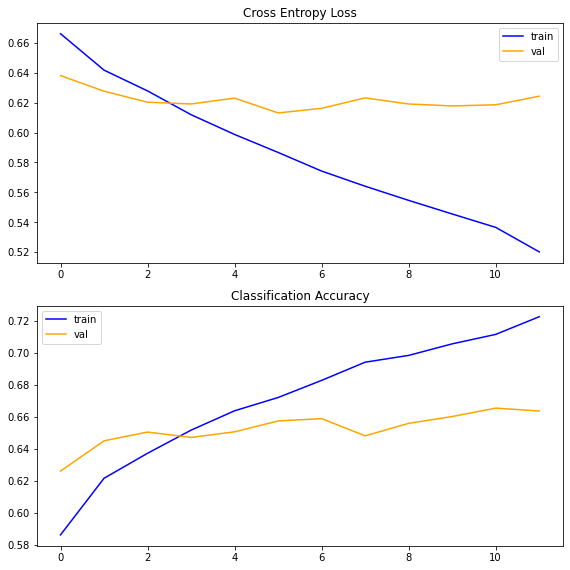

In [32]:
summarize_diagnostics(history_clf_archi01_FILTERED)

### Affichons les scores du modèle

In [33]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_FILTERED.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0


y_preds_proba.shape
y_preds.shape

(20000, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (FILTERED + TF-IDF) -----------------------------------------------------------------

             ROC_AUC : 0.7256
                  F1 : 0.6949
            ACCURACY : 0.6574
           PRECISION : 0.6219
              RECALL : 0.7873
   AVERAGE_PRECISION : 0.7084

       TRAINING-TIME : 77.3753
      INFERENCE-TIME : 0.7291

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.72      0.53      0.61     10088
Prediction = 1       0.62      0.79      0.69      9912

      accuracy                           0.66     20000
     macro avg       

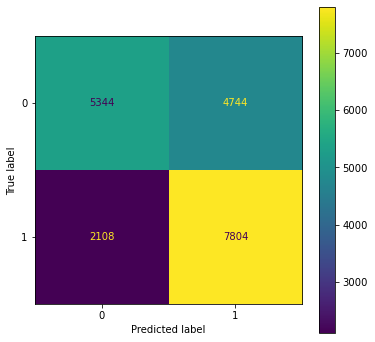

--- ROC AUC ---------------------------------------------------------------------------------------- 



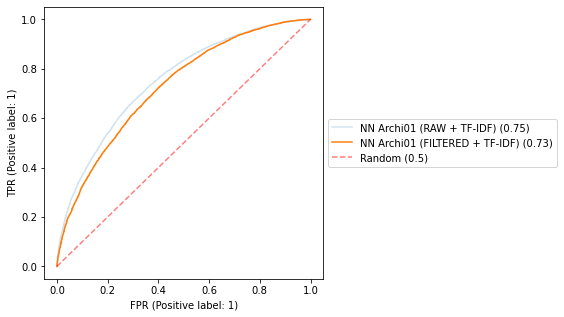

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



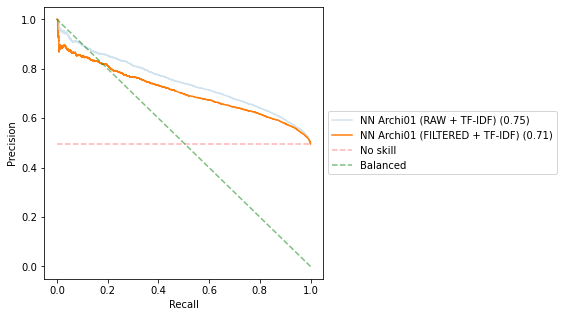

In [34]:
model_name = "NN Archi01 (FILTERED + TF-IDF)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 2.3 TOKENISATION + FILTRAGE + LEMMATIZATION <a class="anchor" id="PREPROCESS_lemmatized"></a> [⇪](#menu)

### Chargeons et appliquons le pré-traitement sur le jeu de données tokenisé & filtré & lemmatisé

In [35]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_lemmas.bin')
data_nlp = joblib.load(data_nlp_path)

In [36]:
data_nlp = data_nlp.sample(sample_size, random_state=random_seed)

In [37]:
display(data_nlp.head(2), data_nlp.shape)

,lemmas,target
33683,"[wretched, weather, note, wash, car]",0
1346934,"[congrat, man, look, like, fierce, eye]",1


(100000, 2)

In [38]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_nlp['lemmas'], data_nlp.target, test_size=0.2, random_state=random_seed)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [39]:
X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, 2000, 35)

----- One sample outputs for demo -----
>> Sentence: ['fucking hero yo']
>> X_train_enc: [[577, 794, 1411]]
>> X_train_ready: [[ 577  794 1411    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]

Vocab size: 31013


### Entrainons notre Neural Network 

In [40]:
embedding = layers.Embedding(vocab_size, 256, trainable=False)

In [41]:
archi01_model_LEMMATIZED = architecture1(f_opti, f_loss, f_metrics, embedding)

In [42]:
archi01_model_LEMMATIZED.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 256)         7939328   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 128)         229504    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1651

In [43]:
t0 = time.perf_counter()
history_clf_archi01_LEMMATIZED = archi01_model_LEMMATIZED.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=32, callbacks=init_callbacks("archi01_LEMMATIZED")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
2500/2500 [==============================] - 7s 3ms/step - loss: 0.6931 - accuracy: 0.5110 - val_loss: 0.6859 - val_accuracy: 0.5694

Epoch 00001: val_accuracy improved from -inf to 0.56935, saving model to models/archi01_LEMMATIZED.epoch01-accuracy0.57.hdf5
Epoch 2/50
2500/2500 [==============================] - 6s 3ms/step - loss: 0.6787 - accuracy: 0.5729 - val_loss: 0.6457 - val_accuracy: 0.6283

Epoch 00002: val_accuracy improved from 0.56935 to 0.62825, saving model to models/archi01_LEMMATIZED.epoch02-accuracy0.63.hdf5
Epoch 3/50
2500/2500 [==============================] - 6s 3ms/step - loss: 0.6536 - accuracy: 0.6134 - val_loss: 0.6354 - val_accuracy: 0.6394

Epoch 00003: val_accuracy improved from 0.62825 to 0.63940, saving model to models/archi01_LEMMATIZED.epoch03-accuracy0.64.hdf5
Epoch 4/50
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6465 - accuracy: 0.6242 - val_loss: 0.6293 - val_accuracy: 0.6455

Epoch 00004: val_accuracy improved from

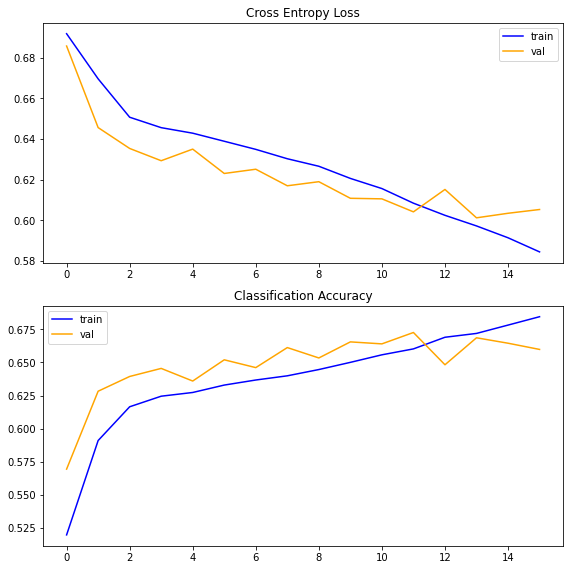

In [44]:
summarize_diagnostics(history_clf_archi01_LEMMATIZED)

### Affichons les scores du modèle

In [45]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_LEMMATIZED.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0


y_preds_proba.shape
y_preds.shape

(20000, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (LEMMATIZED + TF-IDF) ---------------------------------------------------------------

             ROC_AUC : 0.7317
                  F1 : 0.6779
            ACCURACY : 0.6655
           PRECISION : 0.6484
              RECALL : 0.7103
   AVERAGE_PRECISION : 0.7202

       TRAINING-TIME : 101.4748
      INFERENCE-TIME : 0.7215

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.69      0.62      0.65     10088
Prediction = 1       0.65      0.71      0.68      9912

      accuracy                           0.67     20000
     macro avg      

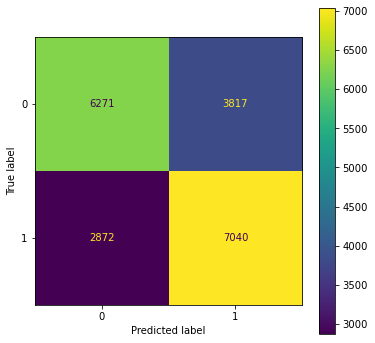

--- ROC AUC ---------------------------------------------------------------------------------------- 



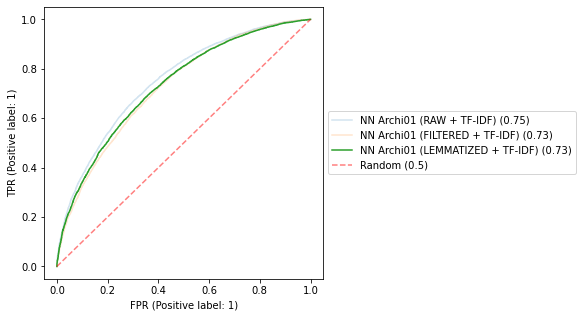

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



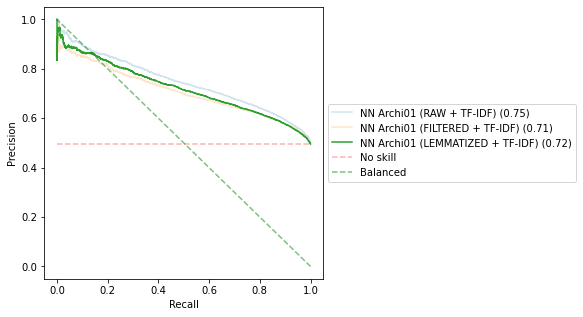

In [46]:
model_name = "NN Archi01 (LEMMATIZED + TF-IDF)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 2.4 Comparaison des `scores` avec les différents pré-traitements <a class="anchor" id="PREPROCESS_scores"></a> [⇪](#menu)

>#### Les scores ci-dessous ont été obtenus avec divers pré-traitements initiaux
> mais la phase final de pré-traitement à dans tous les cas utilisé **TF-IDF** comme moyen de rendre compatible les textes avec le DummyClassifier et la LogisticRegression.

In [47]:
from classification_utils import scores_df

In [48]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,NN Archi01 (RAW + TF-IDF),None,None,0.750729,0.745307,0.711974,0.67430,0.640289,0.801733,8051,5435,4523,1991,70.342930,0.773428
1,NN Archi01 (FILTERED + TF-IDF),None,None,0.725643,0.708399,0.694924,0.65740,0.621932,0.787328,7804,5344,4744,2108,77.375333,0.729089
2,NN Archi01 (LEMMATIZED + TF-IDF),None,None,0.731659,0.720239,0.677933,0.66555,0.648430,0.710250,7040,6271,3817,2872,101.474824,0.721452


>#### Conclusion de la sélection du pré-traitement:
> - Le jeu de données RAW qui a juste été tokenisé *(split)* donne les meilleurs scores, mais prend beaucoup de temps à entrainer.
> - Les jeux de données FILTERED & LEMMATIZED ont des scores sensiblement équivalents, mais nettement inférieur à ceux du RAW.
> - Le jeu de données LEMMATIZED est le plus rapide à entrainer.
>
> A ce stade, si l'on veut augmenter nos scores il convient d'utiliser le jeu de données RAW.

---
---
# 3. Recherche du `plongement` le plus adapté <a class="anchor" id="EMBEDDING"></a> [⇪](#menu)

> https://fr.wikipedia.org/wiki/Word_embedding
>
> Pour utiliser les données en apprentissage machine, il est nécessaire de leur trouver une représentation mathématique, typiquement des vecteurs. Certaines données s'y prêtent directement, comme par exemple les images, qui engendrent des vecteurs riches en information, encodant toutes les nuances et les couleurs qui les composent. Les mots, quant à eux, sont des éléments d'information isolés, et certaines représentations rudimentaires se limitent à un simple identifiant par mot. Par exemple le mot « chat » sera encodé par un seul identifiant arbitraire, disons X87. C'est une représentation discrète, relativement pauvre, qui ne permet notamment pas de comparer deux mots entre eux5. Les plongements lexicaux, eux, représentent un mot par un vecteur. Par exemple, un chat sera représenté par le vecteur [0,43 0,88 0,98 1,3]. Si l'on encode tous les mots d'un dictionnaire ainsi, il devient alors **possible de comparer les vecteurs des mots entre eux**, par exemple en mesurant l'angle entre les vecteurs. Une bonne représentation de mots permettra alors de trouver que le mot « chien » est plus près du mot « chat » qu'il ne l'est du mot « gratte-ciel »6. Qui plus est, ces représentations permettent d'espérer que, dans l'espace vectoriel où le plongement est fait, on aura l'équation roi - homme + femme = reine ou encore l'équation Paris - France + Pologne = Varsovie7.
> 
> Les plongements lexicaux sont également très **utiles pour mitiger le fléau de la dimension**, un problème récurrent en intelligence artificielle. Sans les plongements de mots, **les identifiants uniques représentant les mots engendrent des données éparses**, des points isolés dans un espace vaste et presque vide6. Avec les plongements de mots, en revanche, l'espace devient beaucoup plus restreint et il est plus facile pour un ordinateur d'y établir des regroupements, d'y découvrir des régularités, en apprentissage machine. 

### Chargeons le jeu de données sélectionné à l'étape précédente

In [49]:
data_nlp_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_raw.bin')
data_nlp = joblib.load(data_nlp_path)

In [50]:
# sample_size = 100000
data_nlp = data_nlp.sample(sample_size, random_state=random_seed)

In [51]:
display(data_nlp.head(2), data_nlp.shape)

,tokens_raw,target
1303215,"[@RichGolisch, Thanks!]",1
1121114,"[Trying, to, get, a, babysitter, and, be, 999,...",1


(100000, 2)

In [52]:
# train_x, valid_x, train_y, valid_y, vectorizer = preprocess_data(data_nlp, 'tokens_raw', test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(data_nlp['tokens_raw'], data_nlp.target, test_size=0.2, random_state=random_seed)

---
## 3.1 Word2Vec <a class="anchor" id="EMBEDDING_Word2Vec"></a> [⇪](#menu)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [53]:
from gensim.models import Word2Vec

In [54]:
w2v_model = Word2Vec(X_train, vector_size=256, min_count=5, window=5, sg=0, epochs=100)

In [55]:
pretrained_weights = w2v_model.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Embedding shape:', pretrained_weights.shape)

Embedding shape: (12799, 256)


#### Regardons un peu ce que notre modèle propose comme mots similaires pour quelques mots choisi

In [56]:
for word in ['good', 'bad', 'sad', 'fabulous', 'difficult', 'easy', 'boring', 'fun']:
    if word in w2v_model.wv:
        most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in w2v_model.wv.most_similar(word)[:8])
        print(f'{word.rjust(15)} -> {most_similar}')
    else:
        print(f'⚠️ {word} is not in the Word2Vec vocabulary')

           good -> great (0.59), nice (0.48), wonderful (0.45), rough (0.42), Good (0.41), fantastic (0.41), bad (0.40), fun (0.38)
            bad -> good (0.40), sad (0.35), bad! (0.35), bad, (0.35), bad. (0.35), funny! (0.32), right. (0.31), good. (0.31)
            sad -> upset (0.47), sad. (0.45), sad! (0.45), sad, (0.40), bummed (0.40), happy (0.36), depressed (0.36), excited (0.36)
       fabulous -> great (0.41), good (0.37), nice (0.37), GREAT (0.36), yummy. (0.35), wonderful (0.34), BEAUTIFUL (0.34), awesome (0.32)
      difficult -> hard (0.31), clumsy (0.29), confusing (0.29), important (0.28), honored (0.28), complicated (0.27), dull (0.27), Note (0.27)
           easy -> easier (0.31), hard (0.29), funny (0.28), interesting (0.28), nice (0.28), expensive (0.27), important (0.27), reflect (0.26)
         boring -> good (0.30), bored (0.28), dull (0.28), difficult. (0.27), interesting (0.27), slow (0.27), hectic (0.26), tough (0.26)
            fun -> fun! (0.46), fun. (0.4

#### Mettons notre jeu de données au format requis par tensorflow/keras

In [57]:
def word_embedding_transform(embedding_model, sentences, max_len=65):

    print('\nPreparing the data for Keras NN...')
    train_x = np.zeros([len(sentences), max_len], dtype=np.int32)
    for i, (id,sentence) in enumerate(sentences.iteritems()):
        for t, word in enumerate(sentence[:-1]):
            if word in embedding_model.wv.key_to_index:
                train_x[i, t] = embedding_model.wv.key_to_index[word]
                
    return train_x

In [58]:
X_train_ready = word_embedding_transform(w2v_model, X_train)
print('X_train_ready shape:', X_train_ready.shape, 'y_train shape:', y_train.shape)

X_test_ready = word_embedding_transform(w2v_model, X_test)
print('X_test_ready shape:', X_test_ready.shape, 'y_test shape:', y_test.shape)


Preparing the data for Keras NN...
X_train_ready shape: (80000, 65) y_train shape: (80000,)

Preparing the data for Keras NN...
X_test_ready shape: (20000, 65) y_test shape: (20000,)


#### Ajoutons une fonction permettant de convertir notre embedding word2vec en layer tensorflow/keras

In [59]:
from tensorflow.keras.layers import Embedding

def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

### Entrainons notre Neural Network 

In [60]:
embedding = gensim_to_keras_embedding(w2v_model, train_embeddings=False)

In [61]:
archi01_model_RAW_Word2Vec = architecture1(f_opti, f_loss, f_metrics, embedding)

In [62]:
archi01_model_RAW_Word2Vec.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 256)         3276544   
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 128)         229504    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1651

In [63]:
t0 = time.perf_counter()
history_clf_archi01_RAW_Word2Vec = archi01_model_RAW_Word2Vec.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=32, callbacks=init_callbacks("archi01_RAW_Word2Vec")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
2500/2500 [==============================] - 9s 3ms/step - loss: 0.6974 - accuracy: 0.5332 - val_loss: 0.6161 - val_accuracy: 0.6757

Epoch 00001: val_accuracy improved from -inf to 0.67570, saving model to models/archi01_RAW_Word2Vec.epoch01-accuracy0.68.hdf5
Epoch 2/50
2500/2500 [==============================] - 7s 3ms/step - loss: 0.6215 - accuracy: 0.6594 - val_loss: 0.5816 - val_accuracy: 0.6968

Epoch 00002: val_accuracy improved from 0.67570 to 0.69680, saving model to models/archi01_RAW_Word2Vec.epoch02-accuracy0.70.hdf5
Epoch 3/50
2500/2500 [==============================] - 7s 3ms/step - loss: 0.5998 - accuracy: 0.6795 - val_loss: 0.5694 - val_accuracy: 0.7074

Epoch 00003: val_accuracy improved from 0.69680 to 0.70735, saving model to models/archi01_RAW_Word2Vec.epoch03-accuracy0.71.hdf5
Epoch 4/50
2500/2500 [==============================] - 7s 3ms/step - loss: 0.5891 - accuracy: 0.6878 - val_loss: 0.5623 - val_accuracy: 0.7111

Epoch 00004: val_accuracy improve

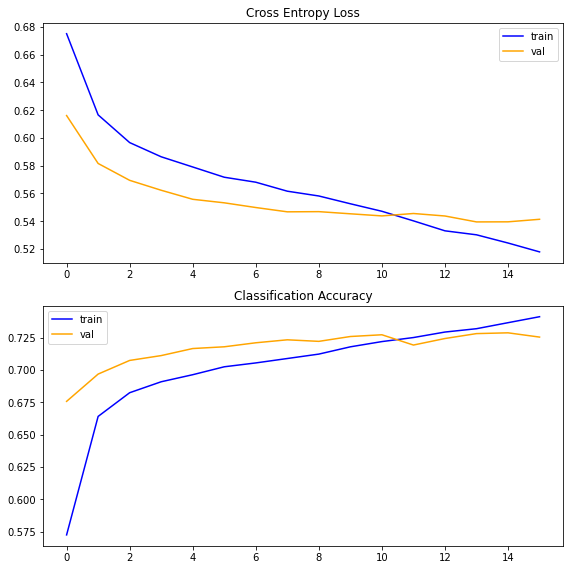

In [64]:
summarize_diagnostics(history_clf_archi01_RAW_Word2Vec)

### Affichons les scores du modèle

In [65]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_RAW_Word2Vec.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

(20000, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (RAW + Word2Vec) --------------------------------------------------------------------

             ROC_AUC : 0.8009
                  F1 : 0.7417
            ACCURACY : 0.7258
           PRECISION : 0.7038
              RECALL : 0.7838
   AVERAGE_PRECISION : 0.7976

       TRAINING-TIME : 112.8700
      INFERENCE-TIME : 0.8605

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.75      0.67      0.71      9958
Prediction = 1       0.70      0.78      0.74     10042

      accuracy                           0.73     20000
     macro avg      

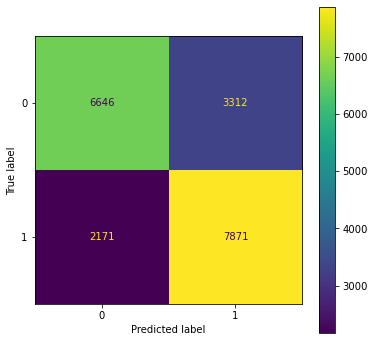

--- ROC AUC ---------------------------------------------------------------------------------------- 



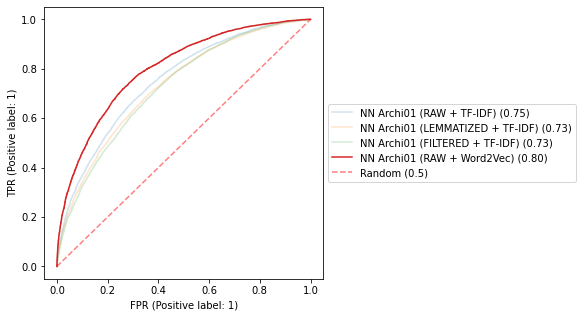

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



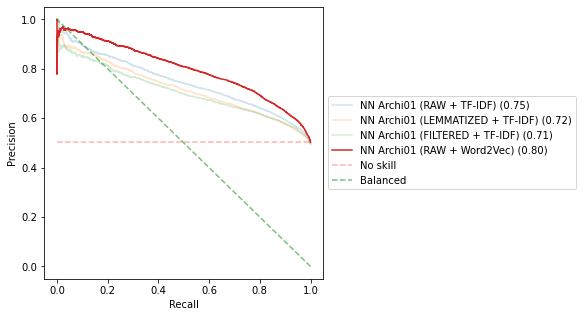

In [66]:
model_name = "NN Archi01 (RAW + Word2Vec)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 3.2 FastText <a class="anchor" id="EMBEDDING_FastText"></a> [⇪](#menu)

### Préparons le jeu de données avec un Tokenizer (Keras)

In [67]:
from gensim.models import FastText

In [68]:
ft_model = FastText(X_train, vector_size=256, min_count=5, window=5, sg=0, epochs=100)

In [69]:
pretrained_weights = ft_model.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Embedding shape:', pretrained_weights.shape)

Embedding shape: (12799, 256)


#### Regardons un peu ce que notre modèle propose comme mots similaires pour quelques mots choisi

In [70]:
for word in ['good', 'bad', 'sad', 'fabulous', 'difficult', 'easy', 'boring', 'fun']:
    if word in ft_model.wv:
        most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in ft_model.wv.most_similar(word)[:8])
        print(f'{word.rjust(15)} -> {most_similar}')
    else:
        print(f'⚠️ {word} is not in the Word2Vec vocabulary')

           good -> goood (0.70), great (0.65), gooood (0.62), good? (0.62), good! (0.60), good!! (0.59), good. (0.57), greasy (0.56)
            bad -> bad? (0.72), bad! (0.69), bad...I (0.67), bad. (0.66), badge (0.64), bad... (0.62), bad, (0.62), badly! (0.59)
            sad -> sad? (0.74), sad! (0.72), sad, (0.71), saddd (0.71), sad. (0.68), sad.. (0.65), sad... (0.61), saddened (0.58)
       fabulous -> fabulous. (0.87), great (0.51), ridiculous (0.49), greatly (0.46), fab (0.45), good (0.45), great! (0.45), wonderful (0.43)
      difficult -> difficult. (0.93), diff (0.58), adult (0.36), hard (0.35), default (0.34), confuse (0.32), confused (0.32), hot (0.32)
           easy -> easy. (0.78), queasy (0.75), greasy (0.64), Easy (0.59), easily (0.51), easier (0.50), easier. (0.47), ease (0.46)
         boring -> boring! (0.83), boring. (0.80), borin (0.80), Boring (0.76), snoring (0.74), exploring (0.67), ignoring (0.56), string (0.55)
            fun -> fun? (0.71), fund (0.70), fu

#### Mettons notre jeu de données au format requis par tensorflow/keras

In [71]:
X_train_ready = word_embedding_transform(ft_model, X_train)
print('X_train_ready shape:', X_train_ready.shape, 'y_train shape:', y_train.shape)

X_test_ready = word_embedding_transform(ft_model, X_test)
print('X_test_ready shape:', X_test_ready.shape, 'y_test shape:', y_test.shape)


Preparing the data for Keras NN...
X_train_ready shape: (80000, 65) y_train shape: (80000,)

Preparing the data for Keras NN...
X_test_ready shape: (20000, 65) y_test shape: (20000,)


### Entrainons notre Neural Network 

In [72]:
embedding = gensim_to_keras_embedding(ft_model, train_embeddings=False)

In [73]:
archi01_model_RAW_FastText = architecture1(f_opti, f_loss, f_metrics, embedding)

In [74]:
archi01_model_RAW_FastText.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 256)         3276544   
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 128)         229504    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 128)         114816    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1651

In [75]:
t0 = time.perf_counter()
history_clf_archi01_RAW_FastText = archi01_model_RAW_FastText.fit(x=X_train_ready, y=y_train, validation_data=(X_test_ready, y_test), epochs=50, batch_size=32, callbacks=init_callbacks("archi01_RAW_FastText")) # , validation_split=0.2 , train_labels
train_time = time.perf_counter() - t0

Epoch 1/50
2500/2500 [==============================] - 7s 3ms/step - loss: 0.7245 - accuracy: 0.5251 - val_loss: 0.6630 - val_accuracy: 0.6109

Epoch 00001: val_accuracy improved from -inf to 0.61095, saving model to models/archi01_RAW_FastText.epoch01-accuracy0.61.hdf5
Epoch 2/50
2500/2500 [==============================] - 7s 3ms/step - loss: 0.6620 - accuracy: 0.6070 - val_loss: 0.6264 - val_accuracy: 0.6506

Epoch 00002: val_accuracy improved from 0.61095 to 0.65055, saving model to models/archi01_RAW_FastText.epoch02-accuracy0.65.hdf5
Epoch 3/50
2500/2500 [==============================] - 7s 3ms/step - loss: 0.6357 - accuracy: 0.6470 - val_loss: 0.6084 - val_accuracy: 0.6740

Epoch 00003: val_accuracy improved from 0.65055 to 0.67395, saving model to models/archi01_RAW_FastText.epoch03-accuracy0.67.hdf5
Epoch 4/50
2500/2500 [==============================] - 7s 3ms/step - loss: 0.6226 - accuracy: 0.6588 - val_loss: 0.5985 - val_accuracy: 0.6805

Epoch 00004: val_accuracy improve

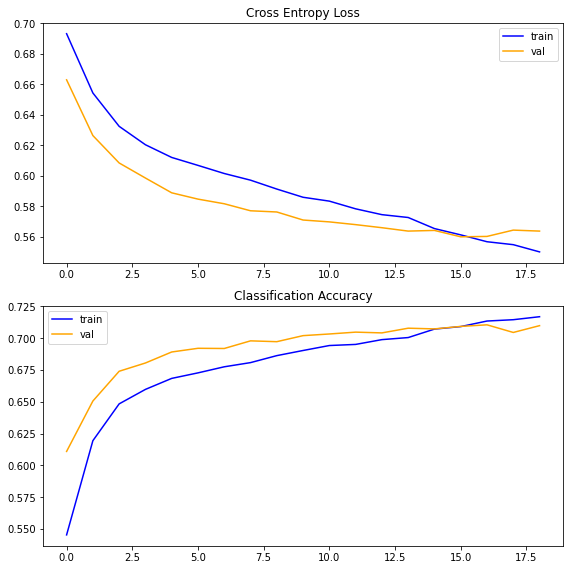

In [76]:
summarize_diagnostics(history_clf_archi01_RAW_FastText)

### Affichons les scores du modèle

In [77]:
t0 = time.perf_counter()
y_preds_proba = archi01_model_RAW_FastText.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

(20000, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (RAW + FastText) --------------------------------------------------------------------

             ROC_AUC : 0.7811
                  F1 : 0.7248
            ACCURACY : 0.7041
           PRECISION : 0.6799
              RECALL : 0.7760
   AVERAGE_PRECISION : 0.7780

       TRAINING-TIME : 131.6215
      INFERENCE-TIME : 0.8654

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.74      0.63      0.68      9958
Prediction = 1       0.68      0.78      0.72     10042

      accuracy                           0.70     20000
     macro avg      

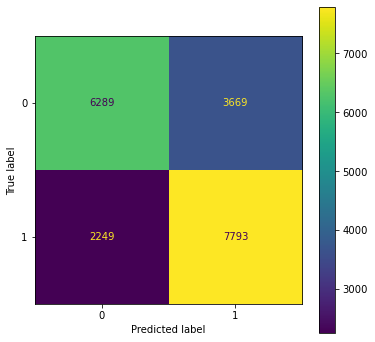

--- ROC AUC ---------------------------------------------------------------------------------------- 



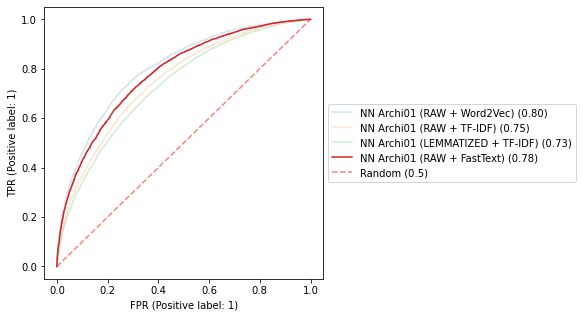

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



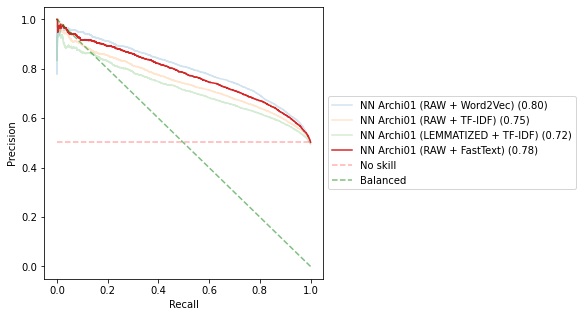

In [78]:
model_name = "NN Archi01 (RAW + FastText)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

---
## 3.3 Comparaison des `scores` avec les différents plongements <a class="anchor" id="EMBEDDING_scores"></a> [⇪](#menu)

In [79]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,NN Archi01 (RAW + TF-IDF),None,None,0.750729,0.745307,0.711974,0.67430,0.640289,0.801733,8051,5435,4523,1991,70.342930,0.773428
1,NN Archi01 (FILTERED + TF-IDF),None,None,0.725643,0.708399,0.694924,0.65740,0.621932,0.787328,7804,5344,4744,2108,77.375333,0.729089
2,NN Archi01 (LEMMATIZED + TF-IDF),None,None,0.731659,0.720239,0.677933,0.66555,0.648430,0.710250,7040,6271,3817,2872,101.474824,0.721452
3,NN Archi01 (RAW + Word2Vec),None,None,0.800907,0.797644,0.741673,0.72585,0.703836,0.783808,7871,6646,3312,2171,112.869989,0.860547
4,NN Archi01 (RAW + FastText),None,None,0.781136,0.778016,0.724795,0.70410,0.679899,0.776041,7793,6289,3669,2249,131.621504,0.865421


>#### Conclusion de la sélection du plongement:
> TODO